In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, networkx as nx 
from sklearn.cluster import KMeans 

In [2]:
"""
Spectral Clustering (Un-Normalized/Normalized)

A: Adjacency matrix 
k: n_clusters 

"""

def spectral_clustering(G, k=10, directed=False, normalization=False): 
    if directed: 
        L = nx.directed_laplacian_matrix(G)         
    else: 
        if normalization: L = nx.laplacian_matrix(G).toarray() 
        else:             L = nx.normalized_laplacian_matrix(G).toarray() 
    
    vals, vecs = np.linalg.eig(L) 
    vecs = vecs[:,np.argsort(vals)] 
    vals = vals[np.argsort(vals)] 
    
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(vecs[:,1:k])
    clusters = kmeans.labels_
    best_cut = vecs[:,1] > 0 
    
    return clusters, best_cut 

In [3]:
from get_graph_from_data import get_graph, draw  
G_di, A_di, G_un, A_un = get_graph(data=pd.read_csv('archive/chicago_taxi_trips_2016_11.csv'), head=True) 
# draw(G_di) 
# draw(G_un) 

<class 'networkx.utils.decorators.argmap'> compilation 9:5: FutureWarning: directed_laplacian_matrix will return a numpy array instead of a matrix in NetworkX 3.0
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


(array([2., 0., 0., 0., 0., 2., 0., 0., 0., 1.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

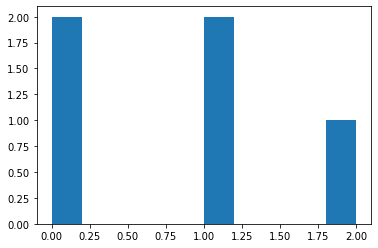

In [4]:
clusters, best_cut = spectral_clustering(G_di, k=3, normalization=False, directed=True) 
plt.hist(clusters)

In [5]:
"""
Spectral Clustering (Un-Normalized/Normalized)

A: Adjacency matrix 
k: n_clusters 

"""
from scipy.linalg import sqrtm, inv

def svd_spectral_clustering(A, d=3, k=3): 
    
    u, s, vh = np.linalg.svd(A, full_matrices=False) 
    U, S, Vh = u[:,:d], s[:d], vh[:d,:] 
    L = U*S@Vh 
    Z1 = U@inv(sqrtm(np.diag(S)))
    Z2 = (Vh.T)@inv(sqrtm(np.diag(S)))
    Z = np.concatenate((Z1, Z2), axis=1)
    print(Z)
    
    vals, vecs = np.linalg.eig(Z) 
    vecs = vecs[:,np.argsort(vals)] 
    vals = vals[np.argsort(vals)] 
    
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(vecs[:,1:k])
    clusters = kmeans.labels_
    best_cut = vecs[:,1] > 0 
    
    return clusters, best_cut 
# svd_spectral_clustering(A_di)

In [6]:
"""
Spectral Clustering (Un-Normalized/Normalized)

A: Adjacency matrix 
k: n_clusters 

"""
def spectral_clustering(A, k=3, normalization=False, directed=False): 
    D = np.diag(A.sum(axis=1)) 
    # L = D-A 
    from scipy.sparse import csgraph 
    if directed: 
        L = csgraph.laplacian(A, normed=normalization) 
    
    vals, vecs = np.linalg.eig(L) 
    vecs = vecs[:,np.argsort(vals)] 
    vals = vals[np.argsort(vals)] 
    
    from sklearn.cluster import KMeans

    kmeans = KMeans(n_clusters=k)
    kmeans.fit(vecs[:,1:k])
    clusters = kmeans.labels_
    print("Clusters:", clusters) 
    
    best_cut = vecs[:,1] > 0 
    
    return clusters, best_cut 

In [7]:
# clusters, best_cut = spectral_clustering(A_un, k=3, normalization=False) 
# plt.hist(clusters) 

In [8]:
# clusters, best_cut = spectral_clustering(A_un, k=3, normalization=True) 
# plt.hist(clusters)

(array([1., 0., 0., 0., 0., 2., 0., 0., 0., 2.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

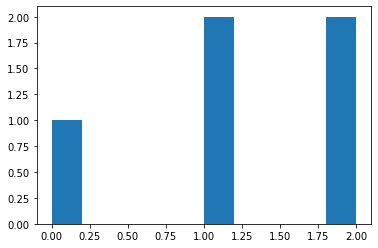

In [9]:
"""
Spectral Clustering (Normalized; Sklearn)

"""

from sklearn.cluster import SpectralClustering 
sc = SpectralClustering(3, affinity='precomputed', n_init=100, assign_labels='discretize') 

# Undirected Graph 
clusters = sc.fit_predict(A_un)
plt.hist(clusters) 

In [10]:
# # Directed Graph 
# clusters = sc.fit_predict(A_di) 
# plt.hist(clusters) 

(array([2., 0., 0., 0., 0., 1., 0., 0., 0., 2.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

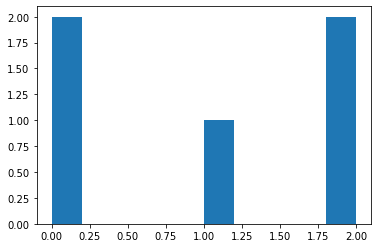

In [11]:
from sklearn.cluster import AgglomerativeClustering 

clustering = AgglomerativeClustering(n_clusters=3).fit(A_un) 
plt.hist(clustering.labels_) 

In [12]:
# import matplotlib.pyplot as plt
# import networkx as nx
# from networkx.algorithms.community.centrality import girvan_newman

# # G = nx.karate_club_graph()

# def gn_algorithm(G):
#     communities = girvan_newman(G)

#     node_groups = []
#     for com in next(communities): 
#         node_groups.append(list(com))

#     print(node_groups)

#     color_map = []
#     for node in G:
#         if node in node_groups[0]:
#             color_map.append('blue')
#         else: 
#             color_map.append('green')  
#     nx.draw(G, node_color=color_map, with_labels=True)
#     plt.show() 
#     return node_groups

In [13]:
# node_groups = gn_algorithm(G_di) 

(array([2., 0., 0., 0., 0., 2., 0., 0., 0., 1.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

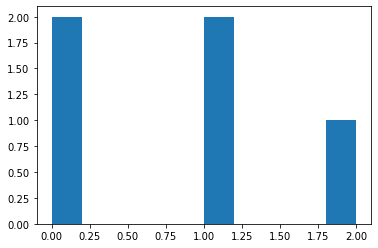

In [14]:
from sknetwork.hierarchy import Paris, cut_straight 
from scipy.cluster.hierarchy import fcluster
paris = Paris()
dendrogram = paris.fit_transform(A_un)
clusters = cut_straight(dendrogram, n_clusters=3)

plt.hist(clusters)

(array([0., 0., 0., 0., 0., 5., 0., 0., 0., 0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

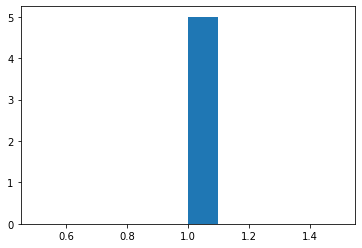

In [15]:
from HCS import labelled_HCS
labels = labelled_HCS(nx.from_numpy_matrix(A_un))
plt.hist(labels)